* https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/transfer/transferlearning-vgg16-cifar10-1.ipynb (do this)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Modified from https://github.com/ieee8023/NeuralNetwork-Examples/blob/master/pytorch/pytorch-mnist.ipynb

import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt 
%matplotlib inline

from torch.autograd import Variable
cuda = torch.cuda.is_available()

torch.manual_seed(0)
if cuda:
    torch.cuda.manual_seed(0)

In [3]:
# Check GPU stuffs
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

1
Tesla P100-PCIE-12GB
True


In [4]:
train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = torchvision.datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=10000,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

train_data = train.train_data
train_data = train.transform(train_data.numpy())

/project/6037045/hasib/envs/pytorch/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [5]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
# get some random training images
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

Traceback (most recent call last):


In [7]:
def imshow(img, label):
    # Convert to numpy
    npimg = img.numpy()
    # Make to w,h from w,h,1
    npimg = npimg.squeeze()
    
    # Plot
    plt.imshow(npimg)
    plt.title("This is a {}".format(label))

  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


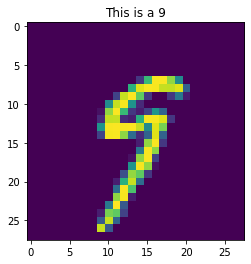

In [8]:
ct = 4000
imshow(x[ct], y[ct])

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view((-1, 784))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h, dim=1)    
    
# Init model
model = None
model = Model()

# Send model to GPU
if cuda:
    model.cuda()

# Init optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [10]:
# Print model
model

Model(
  (fc): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [11]:
# Compute the number of trainable parameters

#model_parameters = filter(lambda p: p.requires_grad, model.parameters())
#params = sum([np.prod(p.size()) for p in model_parameters])
#params

# All parameters
all_params = sum(p.numel() for p in model.parameters())
print("All parameters ", all_params)

# Trainable parameters
all_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters ", all_train_params)

All parameters  795010
Trainable parameters  795010


In [12]:
# get some random training images
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

In [13]:
# train data loader works like this
for b, (d, t) in enumerate(train_loader):
    print(b, d.shape, t.shape)

0 torch.Size([10000, 1, 28, 28]) torch.Size([10000])
1 torch.Size([10000, 1, 28, 28]) torch.Size([10000])
2 torch.Size([10000, 1, 28, 28]) torch.Size([10000])
3 torch.Size([10000, 1, 28, 28]) torch.Size([10000])
4 torch.Size([10000, 1, 28, 28]) torch.Size([10000])
5 torch.Size([10000, 1, 28, 28]) torch.Size([10000])


In [14]:
EPOCHS = 100
losses = []

# Calculate the starting time    
start_time = time.time()

# Set to training model: https://discuss.pytorch.org/t/trying-to-understand-the-meaning-of-model-train-and-model-eval/20158
model.train()

# Start training
for epoch in range(EPOCHS):
    
    # Iterate over dataset in batches of 10,000 images and labels
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = Variable(data), Variable(target)
        
        # Send data to GPU
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Stop grads from piling up
        optimizer.zero_grad()
        
        # Get predictions
        y_pred = model(data) 
        
        # Compute training loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data.item())
        
        # Calc gradients
        loss.backward()
        
        # Update weights
        optimizer.step()

        #if batch_idx % 100 == 1:
        print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch+1,
            EPOCHS,
            batch_idx * len(data), 
            len(train_loader.dataset),
            100. * batch_idx / len(train_loader), 
            loss.cpu().data.item()))
        
        
    # Get whole test data and label
    evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
    evaluate_y = Variable(test_loader.dataset.test_labels)
    
    if cuda:
        evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()
    
    # Inference mode
    model.eval()
    
    # Make predictions
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    
    # Compute test accuracy
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().item()*1./d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.2f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data.item(),
        accuracy*100.0))
    
    

end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))

 Train Epoch: 1/100 [0/60000 (0%)]	Loss: 2.301749
 Train Epoch: 1/100 [10000/60000 (17%)]	Loss: 2.281231
 Train Epoch: 1/100 [20000/60000 (33%)]	Loss: 2.259795
 Train Epoch: 1/100 [30000/60000 (50%)]	Loss: 2.241348
 Train Epoch: 1/100 [40000/60000 (67%)]	Loss: 2.221066
 Train Epoch: 1/100 [50000/60000 (83%)]	Loss: 2.201534
 Train Epoch: 1/100 [60000/60000 (83%)]	Loss: 2.201534	 Test Accuracy: 48.22%


/project/6037045/hasib/envs/pytorch/lib/python3.6/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/project/6037045/hasib/envs/pytorch/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


 Train Epoch: 2/100 [0/60000 (0%)]	Loss: 2.181595
 Train Epoch: 2/100 [10000/60000 (17%)]	Loss: 2.163771
 Train Epoch: 2/100 [20000/60000 (33%)]	Loss: 2.142720
 Train Epoch: 2/100 [30000/60000 (50%)]	Loss: 2.125050
 Train Epoch: 2/100 [40000/60000 (67%)]	Loss: 2.103394
 Train Epoch: 2/100 [50000/60000 (83%)]	Loss: 2.083267
 Train Epoch: 2/100 [60000/60000 (83%)]	Loss: 2.083267	 Test Accuracy: 68.49%
 Train Epoch: 3/100 [0/60000 (0%)]	Loss: 2.065194
 Train Epoch: 3/100 [10000/60000 (17%)]	Loss: 2.046313
 Train Epoch: 3/100 [20000/60000 (33%)]	Loss: 2.027190
 Train Epoch: 3/100 [30000/60000 (50%)]	Loss: 2.002090
 Train Epoch: 3/100 [40000/60000 (67%)]	Loss: 1.985408
 Train Epoch: 3/100 [50000/60000 (83%)]	Loss: 1.965011
 Train Epoch: 3/100 [60000/60000 (83%)]	Loss: 1.965011	 Test Accuracy: 73.18%
 Train Epoch: 4/100 [0/60000 (0%)]	Loss: 1.944029
 Train Epoch: 4/100 [10000/60000 (17%)]	Loss: 1.927472
 Train Epoch: 4/100 [20000/60000 (33%)]	Loss: 1.902970
 Train Epoch: 4/100 [30000/60000 (

In [16]:
def plot_metric(loss):
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.title('Loss')
    plt.ylabel('Performance')
    plt.xlabel('Iterations = Epoch * len(train_loader)')
    plt.legend(['train loss'], loc='center right', fontsize=10)
    plt.grid(False)
    plt.show()

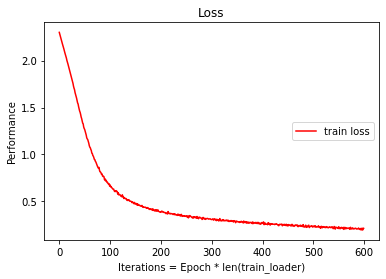

In [17]:
plot_metric(losses)